# Using the implemented Blocks to build a simple ResNet 

<img src="data/The structure of ResNet 12.png" hight="600" width="500">

In [1]:
import numpy as np
from tqdm import tqdm
from collections import namedtuple

import torch
import torch.nn as nn
import torch.nn .functional as F
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable

import matplotlib.pyplot as plt

from utils.utils import conv1x1, conv3x3
from blocks import BasicBlock, BottleneckBlock

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
num_epochs = 20
batch_size = 100
learning_rate = 0.001

#### Load and prepare the data

In [3]:
# Image preprocessing modules
transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()])

# CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                             train=True, 
                                             transform=transform,
                                             download=True)

test_dataset = torchvision.datasets.CIFAR10(root='../../data/',
                                            train=False, 
                                            transform=transforms.ToTensor())

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [45000, 5000])

Files already downloaded and verified


In [7]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                         batch_size=batch_size,
                                         shuffle=False)

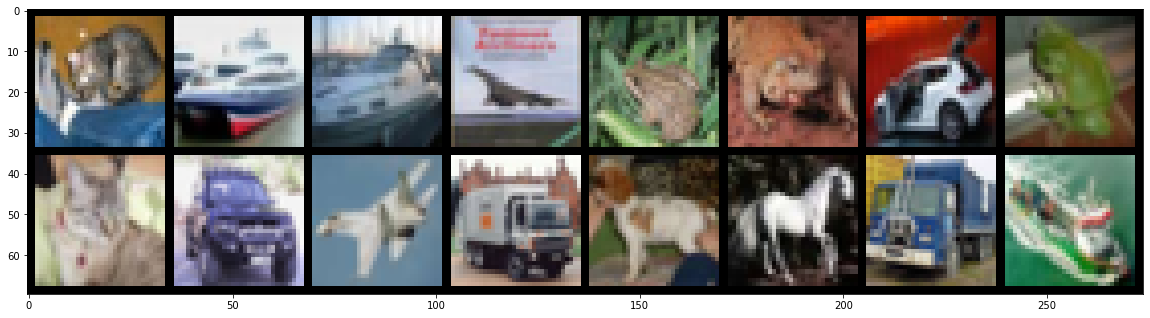

In [8]:
# Show some examples of the data
def imshow(inp, title=None):
    """imshow for Tensor."""
    plt.figure(figsize=(20, 8))
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
#     plt.title(str(' '*18).join(title.numpy()).title())
    plt.imshow(inp)


# Get a batch of training data
images, labels = next(iter(test_loader))

# Make a grid from batch
output = torchvision.utils.make_grid(images[:16])

imshow(output, title=labels[:16])

### ResNet using the Basic Block

In [9]:
# ResNet
class ResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 64)
        self.maxpool = nn.MaxPool2d(3)
#         self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.block1 = BasicBlock.BasicBlock(64)
        self.block2 = BasicBlock.BasicBlock(64)
        self.block3 = BasicBlock.BasicBlock(64)
        self.block4 = BasicBlock.BasicBlock(64)
        self.block5 = BasicBlock.BasicBlock(64)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)
        
        
    def forward(self, x):
        out = self.conv(x)
        out = self.maxpool(out)
        out = self.relu(out)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [14]:
#########################################
#            Trainer Class              #
#########################################

class Trainer:
    
    def __init__(self, model, optimizer, criterion, scheduler=None, load_path=None):
        self.__class__.__name__ = "PyTorch Trainer"
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.scheduler = scheduler
        tqdm.refresh
        ## Setup Metric class
        self.metrics = namedtuple('Metric', ['loss', 'train_error', 'val_error'])
        
        # if model exist
        if load_path:
            self.model = torch.load(load_path)
        
    def save_model(self, path):
        torch.save(self.model.state_dict(), path)
        
    def run(self, train_loader, val_loader):
        min_valid_loss = np.inf
        ## Setup Metric class
        Metric = namedtuple('Metric', ['loss', 'train_error', 'val_error'])
        self.metrics = []
        self.model.train() 
        for epoch in range(num_epochs):
            epoch_loss = 0.0
            correct = 0
            total = 0
            data_iter = enumerate(train_loader)
            t_prog_bar = tqdm(range(len(train_loader)))
#             lr = self.scheduler.get_last_lr()[0]
            lr = self.optimizer.param_groups[0]['lr']
            for step in t_prog_bar: # iter over batches
                
                # get the input images and their corresponding labels
                batch_idx, (data, labels) = next(data_iter)
                # clear the gradient
                self.optimizer.zero_grad()
                # wrap them in a torch Variable and move tnsors to the configured device
                images, labels = Variable(data).to(device), Variable(labels).to(device)                                  
                # Forward Pass
                target = self.model(data)
                # get the predicted class from the maximum value in the output-list of class scores
                pred = target.data.max(1, keepdim=True)[1]
                predicted = pred.eq(labels.data.view_as(pred))
                # Count the correct
                correct += predicted.sum()
                # Find the Loss
                loss = self.criterion(target, labels)
#                 loss = F.nll_loss(target, labels)
                # Backward Pass
                # Calculate gradients
                loss.backward()
                # Update Weights
                self.optimizer.step()
                # Calculate total Loss
                epoch_loss += loss.item()
                # Calculate total samples
                total += labels.size(0)
                
                t_prog_bar.set_description('Epoch {}/{}, Loss: {:.4f}, lr={:.10f}'.format(epoch+1,num_epochs,loss.item(),lr))
                
#                 torch.cuda.empty_cache()
                del images
                del labels
                del loss
                
            valid_loss = 0.0
            self.model.eval() # Optional when not using Model Specific layer
            with torch.no_grad():
                for data, labels in val_loader:
                    # Forward Pass
                    target = self.model(data)
                    # Find the Loss
                    loss = self.criterion(target,labels)
    #                 loss = F.nll_loss(target,labels)
                    # Calculate Loss
                    valid_loss += loss.item()
                    t_prog_bar.set_description('Epoch {}/{}, Loss: {:.4f}, Val_Loss: {:.4f}, lr={:.7f}'\
                                               .format(epoch+1, num_epochs, loss.item(), valid_loss, lr))

            #Check point
            if min_valid_loss > valid_loss:
                print('Validation Loss Decreased ({:.6f} ===> {:.6f}) \nSaving The Model'.format(min_valid_loss/len(val_loader), 
                                                                                                 valid_loss/len(val_loader)))

                min_valid_loss = valid_loss/len(val_loader)

            total_loss = epoch_loss/len(train_loader.dataset)
            train_error = 1.0 - correct/len(train_loader.dataset)  # 1 - acc
            val_error = 1.0 - inference(self.model, val_loader)  # 1 - acc

            self.metrics.append(Metric(loss=epoch_loss, 
                                       train_error=train_error,
                                       val_error=val_error))
            
            # Decrease the lr
            scheduler.step()

In [15]:
#########################################
#             Define the model          #
#           Define the optimizer        #
#           Define the criterion        #
#           Show model summary          #
#########################################
torch_model = ResNet()
# define the criterion
criterion = nn.CrossEntropyLoss()
# define the optimizer
optimizer = torch.optim.Adam(torch_model.parameters(), lr=learning_rate)
# define the scheduler (learninig rate decaying)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.01)

In [16]:
#########################################
#             Model inference           #
#########################################
def inference(model, loader):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for data, labels in loader:
            images = Variable(data).to(device)
            labels = Variable(labels).to(device)
            output = model(images)
            pred = output.data.max(1, keepdim=True)[1]
            predictions = pred.eq(labels.data.view_as(pred))
            total += labels.size(0)
            correct += (predictions == labels).sum().item()
        return correct / total

In [17]:
#########################################
#      Start Training the model         #
#########################################
trainer = Trainer(torch_model, optimizer, criterion)
trainer.run(train_loader, val_loader)

Epoch 1/20, Loss: 1.0390, lr=0.0010000000: 100%|█████████████████████████████████████| 450/450 [03:54<00:00,  1.92it/s]


Validation Loss Decreased (inf ===> 1.318016) 
Saving The Model


Epoch 20/20, Loss: 0.7968, lr=0.0000000000: 100%|████████████████████████████████████| 450/450 [03:47<00:00,  1.98it/s]


### Show the results

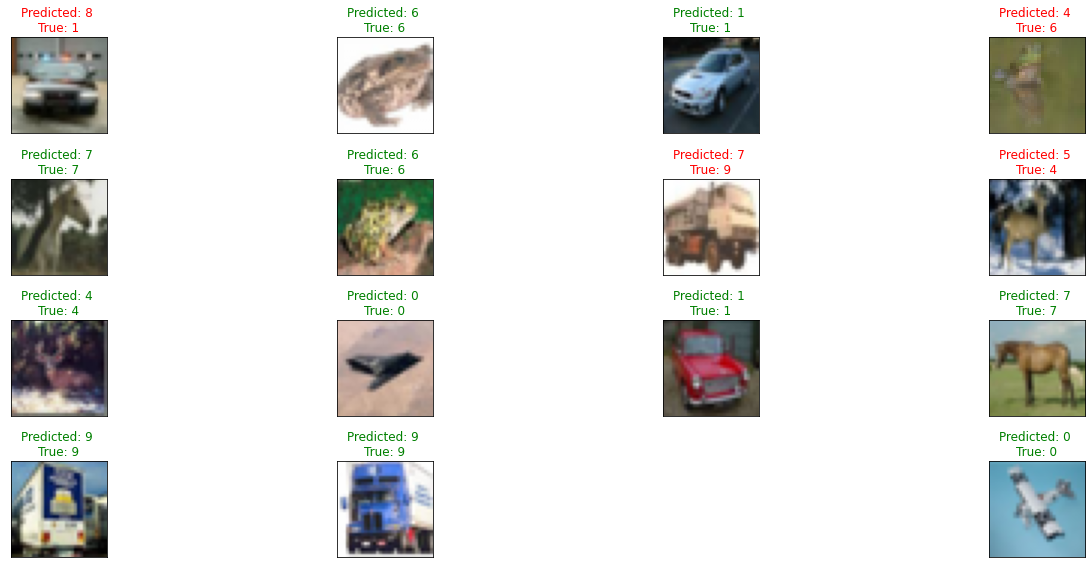

In [18]:
test = iter(test_loader)
plt.figure(figsize=(20, 8))
for i in range(16):
    image, label = next(test)
    idx = np.random.randint(batch_size, size=1)[0]
    output = torch_model(image[[idx]])
    predicted = output.data.max(1, keepdim=True)[1]
    pred = predicted[0][0]
    act = label[idx].numpy().tolist()
    plt.tight_layout()
    plt.subplot(4,4,i+1)
    plt.title("Predicted: {} \nTrue: {}".format(pred, act),color=("green" if pred==act else "red"))
    plt.imshow((np.clip(image[idx].numpy().transpose((1, 2, 0)), 0, 1)))
    plt.xticks([])
    plt.yticks([])

### It's acceptable with this simple model and number of epochs